In [229]:
import os
import sys

print("Current working directory:", os.getcwd())
parent_dir = os.path.dirname(os.getcwd())
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
    print(f"Added {parent_dir} to Python path")
else:
    print(f"{parent_dir} already in Python path")

Current working directory: /Users/jinceyang/Desktop/codebase/ml/learn_d2l/chap2
/Users/jinceyang/Desktop/codebase/ml/learn_d2l already in Python path


In [230]:
import torch

In [231]:
x = torch.tensor(16.).requires_grad_(True)
y = 4 * x
print(y)
y.backward()
print(x.grad)

tensor(64., grad_fn=<MulBackward0>)
tensor(4.)


In [232]:
x = torch.arange(4.0)
x

tensor([0., 1., 2., 3.])

In [233]:
x.requires_grad_(True)
x.grad  # The gradient is None by default

In [234]:
y = 2 * torch.dot(x, x)
y

tensor(28., grad_fn=<MulBackward0>)

In [235]:
y.backward()
x.grad

tensor([ 0.,  4.,  8., 12.])

In [236]:
y = 2 * torch.dot(x, x)
y

tensor(28., grad_fn=<MulBackward0>)

In [237]:
y = x.sum()
y.backward()
x.grad

tensor([ 1.,  5.,  9., 13.])

In [238]:
print(x.grad)
x.grad.zero_() if x.grad is not None else None
y = x.sum()
y.backward()
print(x.grad)

tensor([ 1.,  5.,  9., 13.])
tensor([1., 1., 1., 1.])


In [239]:
x.grad.zero_() if x.grad is not None else None
y = x * x
y.backward(gradient=torch.ones(len(x)))
print(x.grad)

tensor([0., 2., 4., 6.])


## 1. 问题背景：非标量的梯度

通常在深度学习里，我们的 **损失函数** 是一个标量 $L$，这时对参数 $x$ 的梯度 $\nabla_x L$ 没有歧义。但如果你的输出 $y$ 本身是一个 **向量**，例如：

$$
y = f(x) \in \mathbb{R}^m,
$$

那严格来说，$y$ 对 $x$ 的导数是 **Jacobian 矩阵**：

$$
J = \frac{\partial y}{\partial x} \in \mathbb{R}^{m\times n},
$$

其中 $J_{ij} = \frac{\partial y_i}{\partial x_j}$。

所以，**非标量的 backward** 会遇到一个问题：到底要返回一个 Jacobian 矩阵？还是要做点别的？

---

## 2. PyTorch 的做法

PyTorch 默认假设 `backward()` 的目标是一个 **标量**。如果你直接在非标量上调用 `y.backward()`，会报错，因为 PyTorch 不知道是要返回整个 Jacobian 还是你想要别的。

解决办法：**给 PyTorch 一个“权重向量” $v$**，让它计算

$$
v^\top J = \sum_{i=1}^m v_i \nabla_x y_i,
$$

这样就把 $m\times n$ 的 Jacobian 压缩成一个 $1\times n$ 的向量（和 $x$ 同形状），可以作为梯度返回。

在 PyTorch 里，这个向量就是 `backward(gradient=...)` 的 `gradient` 参数。

---

## 3. 代码解释

```python
x.grad.zero_()
y = x * x            # y 也是一个向量，例如 x=[0,1,2,3] → y=[0,1,4,9]
y.backward(gradient=torch.ones(len(y)))
```

* `y = x * x`：如果 `x=[0,1,2,3]`，那么 `y=[0,1,4,9]`。
* 这时 `y` 是一个向量，不能直接 `.backward()`。
* 所以我们给它一个 `gradient=torch.ones(len(y))`，相当于 $v=[1,1,1,1]$。
* PyTorch 实际计算的是：

  $$
  \nabla_x \big( v^\top y \big) = \nabla_x \sum_i v_i y_i = \nabla_x \sum_i y_i.
  $$
* 所以等价于 `y.sum().backward()`。

结果：

```python
x.grad
# tensor([0., 2., 4., 6.])
```

解释：$\frac{\partial}{\partial x} \sum (x_i^2) = 2x$。

---

## 4. 总结

* 对标量 $L$，PyTorch 的 `backward()` 返回正常梯度。
* 对向量 $y$，严格来说梯度是 Jacobian 矩阵，但这太大了，PyTorch 不会默认返回。
* PyTorch 要求你提供一个 **外部权重向量** `gradient`，它会返回 $v^\top J$，这在机器学习里对应于链式法则里从上游传下来的梯度。
* 在大多数场景下，我们想要的是对向量结果求和再反传，所以常见写法是 `y.sum().backward()`。


In [240]:
x.grad.zero_() if x.grad is not None else None
y = x * x
u = y.detach()
z = u * x

z.sum().backward()
(x.grad, u)

(tensor([0., 1., 4., 9.]), tensor([0., 1., 4., 9.]))

In [241]:
x.grad.zero_() if x.grad is not None else None
y.sum().backward()
(x.grad, 2 * x)

(tensor([0., 2., 4., 6.]), tensor([0., 2., 4., 6.], grad_fn=<MulBackward0>))

In [242]:
def f(a):
    b = a * 2
    while b.norm() < 1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c

In [243]:
a = torch.randn(size=(4, )).requires_grad_(True)
d = f(a)
d.sum().backward()
a.grad

tensor([409600., 409600., 409600., 409600.])

In [244]:
a.grad == d / a

tensor([True, True, True, True])

# Exercises

tensor(0.2583) tensor(0.2583, grad_fn=<CosBackward0>)


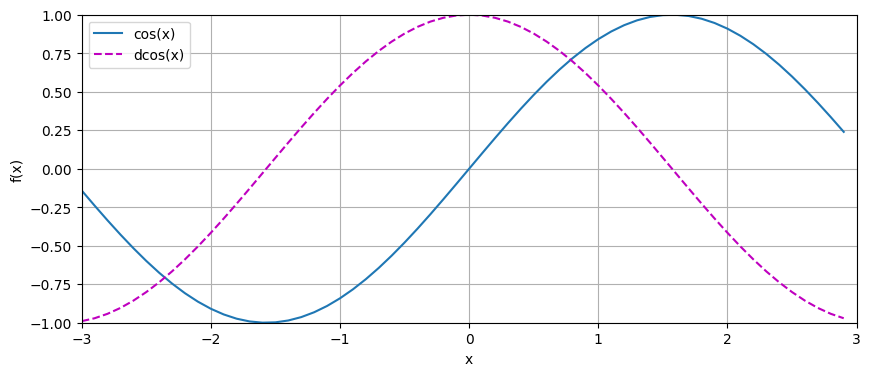

In [245]:
import matplotlib.pyplot as plt
import numpy as np
from d2l import plot

def f(x):
    return torch.sin(x)

x = torch.randn(size=()).requires_grad_(True)
y = f(x)
y.backward()
print(x.grad, torch.cos(x))

x = np.arange(-3.0, 3.0, 0.1)
x_ = [torch.tensor(xi).requires_grad_(True) for xi in x]
y = [f(xi) for xi in x_]
for i in range(len(y)):
    y[i].backward()
dy = np.cos(x)

np_y = np.array([yi.item() for yi in y])
np_dy = np.array([yi.item() for yi in dy])

fig, ax = plt.subplots(figsize=(10, 4))
plot(ax, (x, [np_y, np_dy]), ('x', 'f(x)'), ((-3, 3), (-1, 1)), legend=['cos(x)', 'dcos(x)'])



# 4) 用自动微分画 $f(x)=\sin x$ 及其导数

```python
import torch, numpy as np
import matplotlib.pyplot as plt

xs = torch.linspace(-2*np.pi, 2*np.pi, steps=400, requires_grad=True)
ys = torch.sin(xs)                    # 向量输出
# 对非标量调用 backward 需要上游梯度 v：
ys.backward(gradient=torch.ones_like(ys))   # 等价于 ys.sum().backward()
grads = xs.grad                         # 应该等于 cos(x)

plt.figure(figsize=(5,3))
plt.plot(xs.detach(), ys.detach(), label='sin(x)')
plt.plot(xs.detach(), grads.detach(), label="d/dx sin(x) (autodiff)")
plt.legend(); plt.tight_layout(); plt.show()
```

---

# 5) $f(x)=((\log x^2)\cdot \sin x)+x^{-1}$ 的依赖图（DAG）

设中间量：

* $g_1=x^2$
* $g_2=\log g_1$
* $g_3=\sin x$
* $g_4=g_2\cdot g_3$
* $g_5=x^{-1}$
* $f=g_4+g_5$

边：$x\to g_1\to g_2\to g_4\to f$，以及 $x\to g_3\to g_4$，和 $x\to g_5\to f$。

（注意定义域：$x\ne 0$）

---

# 6) 在图上用链式法则计算 $\mathrm{d}f/\mathrm{d}x$

逐节点的局部导数：

* $g_1'=2x$
* $g_2'=\frac{1}{g_1}\cdot g_1'=\frac{2}{x}$
* $g_3'=\cos x$
* $g_4' = g_2' g_3 + g_2 g_3' = \frac{2}{x}\sin x + \log(x^2)\cos x$
* $g_5' = -x^{-2}$

因此

$$
\boxed{\frac{\mathrm{d}f}{\mathrm{d}x}=
\frac{2}{x}\sin x + \log(x^2)\cos x - \frac{1}{x^2}},\quad x\ne 0.
$$

---

# 7) 前向/反向两种“累计法”各算一遍

## 前向模式（from $x$ to $f$，种子 $x'=\dot x=1$）

* $\dot g_1 = 2x\dot x=2x$
* $\dot g_2 = (1/g_1)\dot g_1 = (1/x^2)(2x)=2/x$
* $\dot g_3 = \cos x\cdot \dot x=\cos x$
* $\dot g_4 = \dot g_2 g_3 + g_2 \dot g_3 = \frac{2}{x}\sin x + \log(x^2)\cos x$
* $\dot g_5 = -x^{-2}\dot x = -1/x^2$
* $\dot f = \dot g_4 + \dot g_5$（即上面的结果）

## 反向模式（from $f$ back to $x$，用伴随/反向灵敏度 $\bar{\cdot}$）

初始化 $\bar f=1$：

* $f=g_4+g_5:\ \bar g_4{+}=1,\ \bar g_5{+}=1$
* $g_4=g_2 g_3:\ \bar g_2{+}=\bar g_4\cdot g_3,\ \bar g_3{+}=\bar g_4\cdot g_2$
* $g_2=\log g_1:\ \bar g_1{+}=\bar g_2\cdot (1/g_1)$
* $g_3=\sin x:\ \bar x{+}=\bar g_3\cdot \cos x$
* $g_1=x^2:\ \bar x{+}=\bar g_1\cdot 2x$
* $g_5=x^{-1}:\ \bar x{+}=\bar g_5\cdot (-x^{-2})$

最终 $\bar x=\mathrm{d}f/\mathrm{d}x$，与上式一致。

---

# 8) 何时用前向，何时用反向？

* 设输入维数 $n=\dim(x)$，输出维数 $m=\dim(y)$。
* **前向模式（forward-mode）**：一次传播得到 **某个输入方向** 的导数（或对单个标量输入的全部输出导数）。
  **适合 $n \ll m$**（输入少、输出多），内存占用小，容易并行每个输入方向。
* **反向模式（reverse-mode / backprop）**：一次反传得到 **对所有输入的梯度**（针对一个标量输出）。
  **适合 $m=1$, $n$ 很大**（典型深度学习：损失是标量、参数成千上万）。代价与一次前向同阶，但需要保留中间激活以便反传，内存更大。
* 实操提示：

  * 标量损失对大量参数求梯度 → 反向模式。
  * 少量参数控制产生高维输出（如灵敏度分析、微分方程求解中的参数导数）→ 前向模式或多次前向。
  * 二阶信息通常用 **Hessian-向量积 (HVP)**，其成本 \~ 一次梯度，避免构建整个 Hessian。

---
